In [1]:
from sklearn.model_selection import KFold
from kan import KAN, LBFGS
import torch
import matplotlib.pyplot as plt
from torch import autograd
from tqdm import tqdm
from scipy.stats import norm
import numpy as np

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cpu


In [3]:

# Black-Scholes function for option pricing
def black_scholes(S, K, T, r, sigma):
    """
    S: current stock price
    K: strike price
    T: time to maturity (in years)
    r: risk-free interest rate
    sigma: volatility of the underlying asset
    """
    # Add small epsilon values to avoid divide-by-zero errors
    T = np.maximum(T, 1e-10)
    sigma = np.maximum(sigma, 1e-10)

    d1 = (np.log(S / K) + (r + 0.5 * sigma**2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)
    
    price = S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    
    return price


In [4]:

# Define the Black-Scholes analytical solution function
def sol_fun(x):
    S = x[:, 0]  # Stock price
    t = x[:, 1]  # Time
    K = 100  # Strike price
    r = 0.05  # Risk-free interest rate
    sigma = 0.2  # Volatility
    T = 1  # Time to maturity (can be adjusted)

    # Time to maturity is T - t
    tau = T - t

    # Use the Black-Scholes formula to get the price
    price = black_scholes(S.cpu().numpy(), K, tau.cpu().numpy(), r, sigma)
    
    return torch.tensor(price, dtype=torch.float32).reshape(-1, 1).to(device)

In [5]:

# Source function for the Black-Scholes PDE is zero
source_fun = lambda x: torch.zeros_like(x[:, [0]]).to(device)


In [6]:

# Interior points (Stock prices and Time)
np_i = 51  # You can change this based on grid resolution

S_mesh = torch.linspace(50, 150, steps=np_i)  # Stock prices from 50 to 150
t_mesh = torch.linspace(0, 1, steps=np_i)  # Time from 0 to 1 (year)
S_grid, t_grid = torch.meshgrid(S_mesh, t_mesh, indexing="ij")

x_i = torch.stack([S_grid.reshape(-1,), t_grid.reshape(-1,)]).permute(1, 0).to(device)

In [7]:
def batch_jacobian(func, x, create_graph=False):
    # x in shape (Batch, Length)
    def _func_sum(x):
        return func(x).sum(dim=0)
    return autograd.functional.jacobian(_func_sum, x, create_graph=create_graph).permute(1,0,2)

In [8]:

# boundary, 4 sides
helper = lambda X, Y: torch.stack([X.reshape(-1,), Y.reshape(-1,)]).permute(1, 0)
xb1 = helper(S_grid[0], t_grid[0])
xb2 = helper(S_grid[-1], t_grid[0])
xb3 = helper(S_grid[:, 0], t_grid[:, 0])
xb4 = helper(S_grid[:, 0], t_grid[:, -1])
x_b = torch.cat([xb1, xb2, xb3, xb4], dim=0).to(device)

In [11]:

# Split interior points into train and test sets (80/20)
train_size = int(0.8 * x_i.size(0))
test_size = x_i.size(0) - train_size

indices = torch.randperm(x_i.size(0))
train_indices = indices[:train_size]
test_indices = indices[train_size:]

x_train_full = x_i[train_indices]
x_test = x_i[test_indices]

# K-Fold Cross Validation setup
kf = KFold(n_splits=3, shuffle=True)

In [12]:

alpha = 0.01
log = 1

grids = [5, 10, 20]
steps = 50

pde_losses = []
bc_losses = []
l2_losses = []

for fold, (train_idx, val_idx) in enumerate(kf.split(x_train_full)):
    print(f'Fold {fold+1}')

    x_train = x_train_full[train_idx]
    x_val = x_train_full[val_idx]

    for grid in grids:
        if grid == grids[0]:
            model = KAN(width=[2, 2, 1], grid=grid, k=3, seed=1, device=device)
            model = model.speed()
        else:
            model.save_act = True
            model.get_act(x_train)
            model = model.refine(grid)
            model = model.speed()

        def train():
            optimizer = LBFGS(model.parameters(), lr=1, history_size=10, line_search_fn="strong_wolfe", tolerance_grad=1e-32, tolerance_change=1e-32, tolerance_ys=1e-32)

            pbar = tqdm(range(steps), desc=f'Fold {fold+1} | Training', ncols=100)

            for _ in pbar:
                def closure():
                    global pde_loss, bc_loss
                    optimizer.zero_grad()

                    # Compute the solution using the Black-Scholes formula
                    sol = sol_fun(x_train)

                    # First-order and second-order derivatives
                    sol_D1_fun = lambda x: batch_jacobian(model, x, create_graph=True)[:, 0, :]
                    sol_D1 = sol_D1_fun(x_train)
                    sol_D2 = batch_jacobian(sol_D1_fun, x_train, create_graph=True)[:, :, :]

                    # Laplacian calculation (finite difference for derivatives)
                    delta_t = 1.0 / (np_i - 1)  # Assuming equal spacing
                    delta_S = (S_mesh[-1] - S_mesh[0]) / (np_i - 1)

                    pdf_pdt = (sol_D1[:, 1] - sol_fun(x_train)[:, 0]) / delta_t

                    pdf_pds = 0.5 * (
                        (sol_fun(x_train[1:, 1:]) - sol_fun(x_train[:-1, 1:])) / delta_S +
                        (sol_fun(x_train[:, 1:]) - sol_fun(x_train[:, :-1])) / delta_S
                    )

                    pd2f_pds2 = (
                        (sol_fun(x_train[1:, 1:]) + sol_fun(x_train[:-1, :-1]) - 2 * sol_fun(x_train[:, :-1])) / delta_S**2
                    )

                    lap = pdf_pdt + pdf_pds + pd2f_pds2

                    source = source_fun(x_train)  # Zero source
                    pde_loss = torch.mean((lap - source) ** 2)

                    # Boundary condition loss
                    bc_true = sol_fun(x_b)
                    bc_pred = model(x_b)
                    bc_loss = torch.mean((bc_pred - bc_true) ** 2)

                    # Overall loss
                    loss = alpha * pde_loss + bc_loss
                    loss.backward()
                    return loss


                if _ % 5 == 0 and _ < 20:
                    model.update_grid_from_samples(x_train)

                optimizer.step(closure)
                sol = sol_fun(x_train)
                loss = alpha * pde_loss + bc_loss
                l2 = torch.mean((model(x_train) - sol) ** 2)

                if _ % log == 0:
                    pbar.set_description(f"Fold {fold+1} | pde loss: {pde_loss:.2e} | bc loss: {bc_loss:.2e} | l2: {l2:.2e}")

                pde_losses.append(pde_loss.cpu().detach().numpy())
                bc_losses.append(bc_loss.cpu().detach().numpy())
                l2_losses.append(l2.cpu().detach().numpy())

            # Validation loss calculation
            model.eval()
            with torch.no_grad():
                val_sol = sol_fun(x_val)
                val_l2 = torch.mean((model(x_val) - val_sol) ** 2)
                print(f"Validation L2 loss for Fold {fold+1}: {val_l2}")

        train()

Fold 1
checkpoint directory created: ./model
saving model version 0.0


Fold 1 | pde loss: 9.13e+00 | bc loss: 2.08e-01 | l2: 2.15e-01: 100%|█| 50/50 [00:34<00:00,  1.46it/


Validation L2 loss for Fold 1: 0.21608692407608032


Fold 1 | pde loss: 1.40e+00 | bc loss: 4.50e-02 | l2: 1.26e-01: 100%|█| 50/50 [00:34<00:00,  1.44it/


Validation L2 loss for Fold 1: 0.12668825685977936


Fold 1 | pde loss: 1.07e+00 | bc loss: 1.70e-02 | l2: 1.08e-01: 100%|█| 50/50 [00:44<00:00,  1.13it/


Validation L2 loss for Fold 1: 0.11815261095762253
Fold 2
checkpoint directory created: ./model
saving model version 0.0


Fold 2 | pde loss: 1.79e+00 | bc loss: 1.91e-01 | l2: 1.45e-01: 100%|█| 50/50 [00:33<00:00,  1.49it/


Validation L2 loss for Fold 2: 0.14470957219600677


Fold 2 | pde loss: 1.29e+00 | bc loss: 1.72e-02 | l2: 9.80e-02: 100%|█| 50/50 [00:38<00:00,  1.31it/


Validation L2 loss for Fold 2: 0.0917709693312645


Fold 2 | pde loss: 1.17e+00 | bc loss: 6.18e-03 | l2: 9.59e-02: 100%|█| 50/50 [00:46<00:00,  1.07it/


Validation L2 loss for Fold 2: 0.08729240298271179
Fold 3
checkpoint directory created: ./model
saving model version 0.0


Fold 3 | pde loss: 1.02e+01 | bc loss: 2.56e-01 | l2: 2.65e-01: 100%|█| 50/50 [00:40<00:00,  1.25it/


Validation L2 loss for Fold 3: 0.24806664884090424


Fold 3 | pde loss: 9.55e+00 | bc loss: 5.66e-02 | l2: 1.35e-01: 100%|█| 50/50 [00:37<00:00,  1.33it/


Validation L2 loss for Fold 3: 0.13505570590496063


Fold 3 | pde loss: 9.44e+00 | bc loss: 3.45e-02 | l2: 1.30e-01: 100%|█| 50/50 [00:25<00:00,  1.96it/

Validation L2 loss for Fold 3: 0.127068430185318


In [15]:
model.save_act = True  # This saves the activations
model.get_act(x_train)  # Activations should be computed for the training data

# After K-Fold cross-validation, evaluate on the test set
model.eval()
with torch.no_grad():
    test_sol = sol_fun(x_test)
    test_l2 = torch.mean((model(x_test) - test_sol) ** 2)
    print(f"Final Test L2 loss: {test_l2}")


Final Test L2 loss: 0.13152223825454712


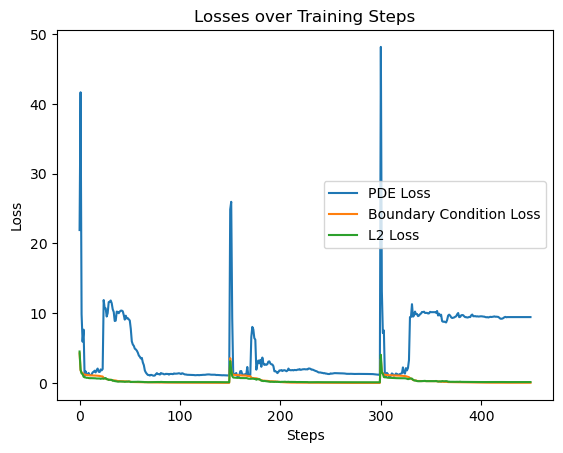

    function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        exp    0.999778 -12.073788           2                2   -0.814758
1        1/x    0.999591 -11.219097           2                2   -0.643819
2    1/x^0.5    0.999481 -10.885156           2                2   -0.577031
3  1/sqrt(x)    0.999481 -10.885156           2                2   -0.577031
4        x^2    0.999415 -10.714342           2                2   -0.542868
  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0        x    1.000000 -16.584071           1                1   -2.516814
1      exp    0.999999 -16.447161           2                2   -1.689432
2    1/x^2    0.999997 -16.233324           2                2   -1.646665
3      1/x    0.999997 -16.226715           2                2   -1.645343
4      cos    0.999970 -14.599607           2                2   -1.319921
  function  fitting r2    r2 loss  complexity  complexity loss  total loss
0      sin   

In [19]:
### Model Plot: Visualizing the Model Results
plt.plot(pde_losses, label="PDE Loss")
plt.plot(bc_losses, label="Boundary Condition Loss")
plt.plot(l2_losses, label="L2 Loss")
plt.title("Losses over Training Steps")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.legend()
plt.show()

### Generate Symbolic Formula: Defining a Complex Symbolic Function Suggested by the Model
# Example of KAN symbolic regression feature
for i in range(2):
    for j in range(2):
        model.suggest_symbolic(0, i, j)

for i in range(2):
    model.suggest_symbolic(1, i, 0)

# Retrieve the generated symbolic formula
formula, var = model.symbolic_formula()
print("Generated Symbolic Formula: ", formula)

### Final Black-Scholes Calculation: Prints the Black-Scholes Price Using the Defined Function
S = 100  # Example stock price
K = 100  # Example strike price
T = 1    # Time to maturity
r = 0.05 # Risk-free rate
sigma = 0.13 # Volatility

# Compute Black-Scholes price
bs_price = black_scholes(S, K, T, r, sigma)
print(f"Final Black-Scholes Price: {bs_price}")

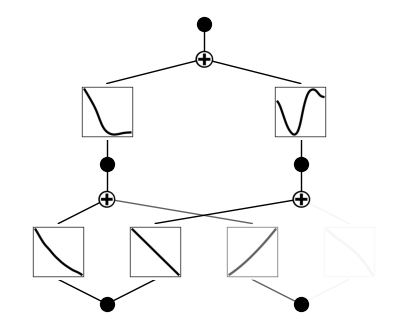

In [17]:
model.plot(beta=10)